In [1]:
import numpy as np
import pandas as pd
import os.path
import os
from time import sleep
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from fastnode2vec import Graph, Node2Vec


In [3]:
!pip freeze


absl-py==0.9.0
astor==0.8.0
attrs==19.3.0
backcall==0.1.0
bleach==3.1.5
blinker==1.4
boto==2.49.0
boto3==1.14.60
botocore==1.17.60
cachetools==3.1.1
catboost==0.23.1
certifi==2020.4.5.1
cffi==1.14.0
chardet==3.0.4
click==7.1.2
colorama==0.4.3
cryptography==2.9.2
cycler==0.10.0
Cython==0.29.14
decorator==4.4.2
defusedxml==0.6.0
docutils==0.15.2
entrypoints==0.3
fastnode2vec==0.0.5
gast==0.2.2
gensim==3.8.3
google-auth==1.14.1
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
graphviz==0.14
grpcio==1.27.2
h5py==2.10.0
idna==2.9
importlib-metadata==1.6.0
ipykernel==5.3.0
ipython==7.14.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.17.0
Jinja2==2.11.2
jmespath==0.10.0
joblib==0.15.1
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.3
jupyter-console==6.1.0
jupyter-core==4.6.3
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.0
kiwisolver==1.2.0
llvmlite==0.34.0
Markdown==3.1.1
MarkupSafe==1.1.1
matplotlib==3.2.1
mistune==0.8.4
mkl-fft==1.0.15
mkl-random==1.1.0
mkl-service==2.3.0
nbc

# Aggregate and transform data

In [2]:
def parse_all_contributors_files():
    users_data_files = os.listdir('users')
    all_files = set()
    contributors_info = []

    for filename in users_data_files:
        user_data = open(os.path.join('users', filename), 'r').readlines()
        login = user_data[0][:-1]
        changed_files = user_data[1:]
        contributors_info.append((login, changed_files))
        all_files = all_files.union(set(changed_files))
    
    return all_files, contributors_info


def create_df_from_contributors_info(all_files, contributors_info):
    ohe_contributors_info = {'login':[]}

    for filename in all_files:
        ohe_contributors_info[filename] = np.zeros(len(contributors_info))
    
    for i, contributor_info in enumerate(contributors_info):
        ohe_contributors_info['login'].append(contributor_info[0])
        for filename in contributor_info[1]:
            ohe_contributors_info[filename][i] = 1
    
    df = pd.DataFrame(ohe_contributors_info)
    df.to_csv(os.path.join(*['data','contributor_changed_files.csv']))


all_files, contributors_info = parse_all_contributors_files()
create_df_from_contributors_info(all_files, contributors_info)

In [3]:
df = pd.read_csv(os.path.join(*['data','contributor_changed_files.csv']), index_col=0)
df.head(5)

,login,packages/react-dom/src/client/event/SyntheticAnimationEvent.js\n,scripts/rollup/shims/facebook-www/EventPluginHub.js\n,src/addons/transitions/ReactCSSTransitionGroupChild.js\n,packages/schedule/src/TracingSubscriptions.js\n,scripts/jest/matchers/interactionTracing.js\n,src/shared/vendor/core/camelize.js\n,scripts/rollup/shims/rollup/ReactComponentTreeHookRollupShim.js\n,React/memoizeStringOnly.js\n,packages/react-devtools-shared/src/backend/legacy/utils.js\n,...,packages/react-events/src/dom/__tests__/ContextMenu-test.internal.js\n,packages/schedule/src/Schedule.js\n,src/utils/__tests__/accumulateInto-test.js\n,packages/react-codemod/test/pure-render-mixin-test3.output.js\n,fixtures/attribute-behavior/src/App.js\n,packages/react-interactions/accessibility/src/TabbableScope.js\n,packages/react-reconciler/src/ReactDebugFiberPerf.js\n,shells/dev/app/Toggle/index.js\n,packages/react-dom/server.js\n,src/renderers/dom/client/__tests__/inputValueTracking-test.js\n
0,acdlite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,aickin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,arkist,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aweary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,benjamn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
login_to_index = {login:i for i, login in enumerate(df.login)}
index_to_login = {i:login for i, login in enumerate(df.login)}


def distance_by_files_intersection(files_u, files_v):
    return sum(np.bitwise_and(files_u, files_v))


def create_list_of_edges(df):
    edges_list = []
    for row_v in df.iterrows():
        v = login_to_index[row_v[1]['login']]
        files_v = row_v[1].drop(['login']).values.astype(np.bool)
        for row_u in df.iterrows():
            u = login_to_index[row_u[1]['login']]
            if v == u:
                break
            files_u = row_u[1].drop(['login']).values.astype(np.bool)
            dist = distance_by_files_intersection(files_u, files_v)
            if dist > 0:
                edges_list.append((v, u, {'weight':dist}))
    return edges_list


def add_contributions_count_to_label(index_to_login):
    index_to_login_ = dict()
    for row in df.iterrows():
        login = row[1]['login']
        files = np.sum(row[1].drop(['login']))
        i = login_to_index[login]
        index_to_login_[i] = login + ' - ' + str(int(files))
    return index_to_login_


edges_list = create_list_of_edges(df)

# Visualization

## File modification data + TSNE
We can use descriptions of file modification for each user as already done representations. Just use TSNE for reduse dimensionality and visualize it.

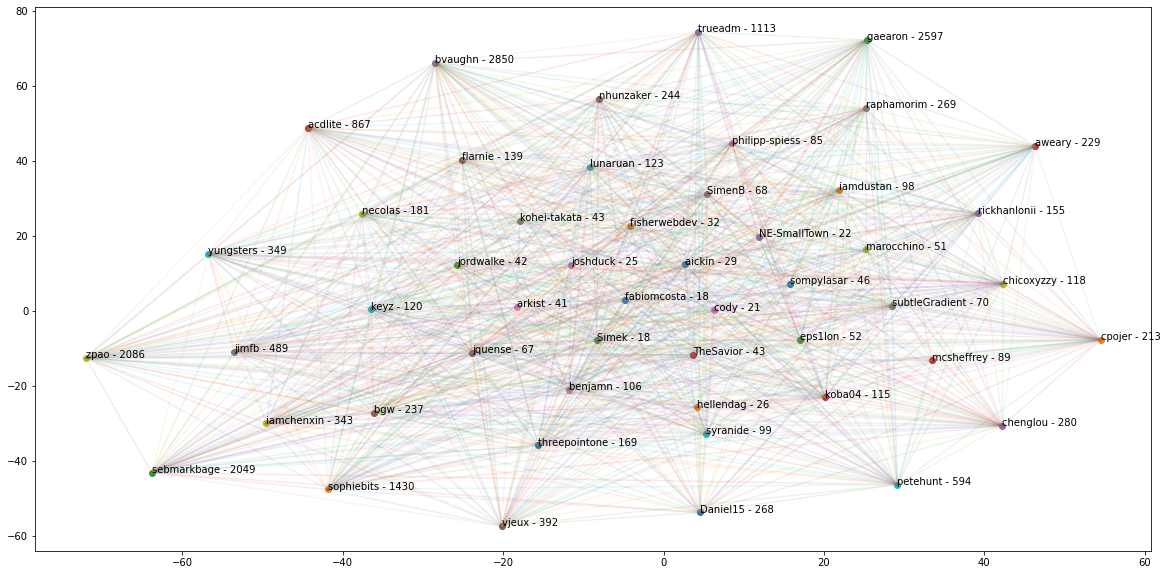

In [5]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.pyplot as plt


def tsne2d_representation(df):
    t = TSNE(random_state=321)
    t_repr = t.fit_transform(df)
    return t_repr


def draw_points(t_repr, df, index_to_login=index_to_login):
    colors = cm.rainbow(np.linspace(0, 1, df.shape[0]))
    for y, c in zip(set(df.login), colors):
        plt.scatter(t_repr[df.login==y, 0], 
                    t_repr[df.login==y, 1], alpha=1)
        label = index_to_login[login_to_index[y]]
        plt.annotate(label, (t_repr[df.login==y, 0], 
                    t_repr[df.login==y, 1]))


def draw_edges(t_repr, edges_list, df):
    for u, v,_ in edges_list:
        u = index_to_login[u]
        v = index_to_login[v]
        x = [t_repr[df.login==u, 0], t_repr[df.login==v, 0]]
        y = [t_repr[df.login==u, 1], t_repr[df.login==v, 1]]
        plt.plot(x, y, '-', alpha=0.1)


def draw_representation(t_repr, edges_list, df, index_to_login=index_to_login):
    plt.figure(figsize=(20,10))
    draw_points(t_repr, df, index_to_login=index_to_login)
    draw_edges(t_repr, edges_list, df)


index_to_login_ = add_contributions_count_to_label(index_to_login)
t_repr = tsne2d_representation(df.drop(['login'], axis=1))
draw_representation(t_repr, edges_list, df, index_to_login_)
plt.show()

This is noninformative.

## Draw graph using networkx

In [6]:
def create_nx_graph(edges_list):
    g = nx.Graph()
    g.add_edges_from(edges_list)
    return g


def draw_nx_nodes(g, pos):
    nx.draw_networkx_nodes(g, pos=pos, node_color=range(1, 51), cmap=plt.cm.rainbow,
                         alpha=0.4, node_size=125)


def draw_nx_edges(g, pos, dynamic_width=False):
    edges = g.edges()
    weights = [int(np.log(g[u][v]['weight']+1)) for u,v in edges]
    if dynamic_width:
        nx.draw_networkx_edges(g, pos=pos, alpha=0.1, width=weights) 
    else:
        nx.draw_networkx_edges(g, pos=pos, alpha=0.1)


def draw_nx_graph(g, index_to_login, dynamic_width=False):
    plt.figure(figsize=(20,12))
    g = nx.relabel_nodes(g, index_to_login)
    pos = nx.spring_layout(g, seed=1337)
    draw_nx_nodes(g, pos)
    draw_nx_edges(g, pos, dynamic_width=dynamic_width)
    nx.draw_networkx_labels(g, pos=pos, font_size=10)


g = create_nx_graph(edges_list)

Draw graph with labels - (login, files changed). Nodes with greater edge weights will be closer to each other. 

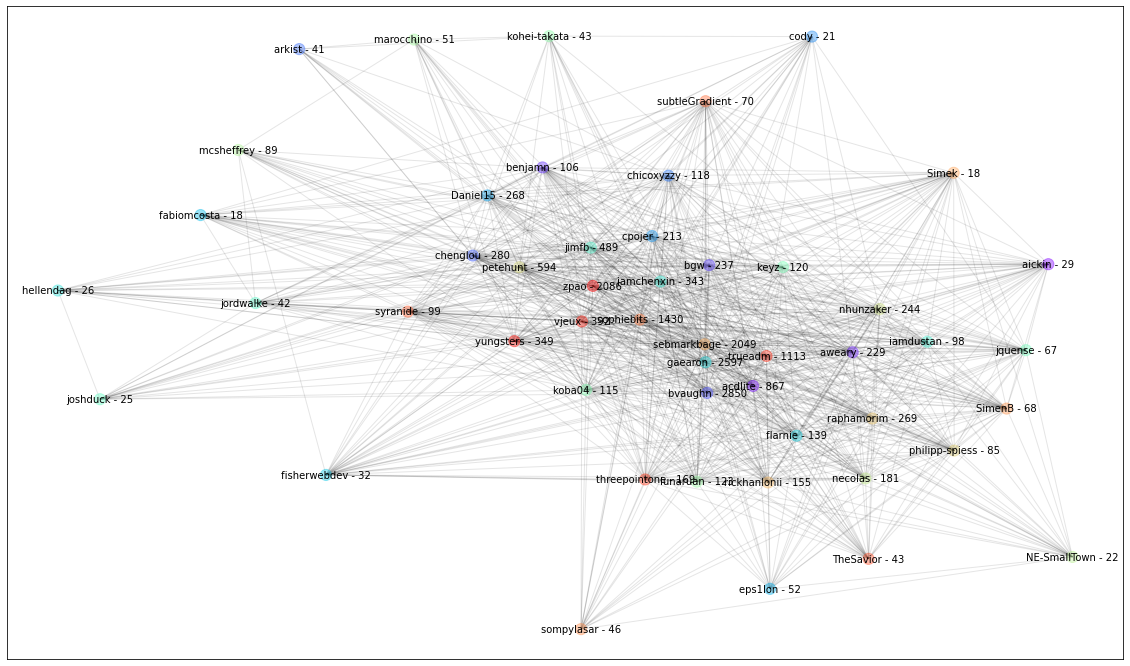

In [7]:
index_to_login_ = add_contributions_count_to_label(index_to_login) # show count of changed files
draw_nx_graph(g, index_to_login_)


Draw each edge with width according to its weight.

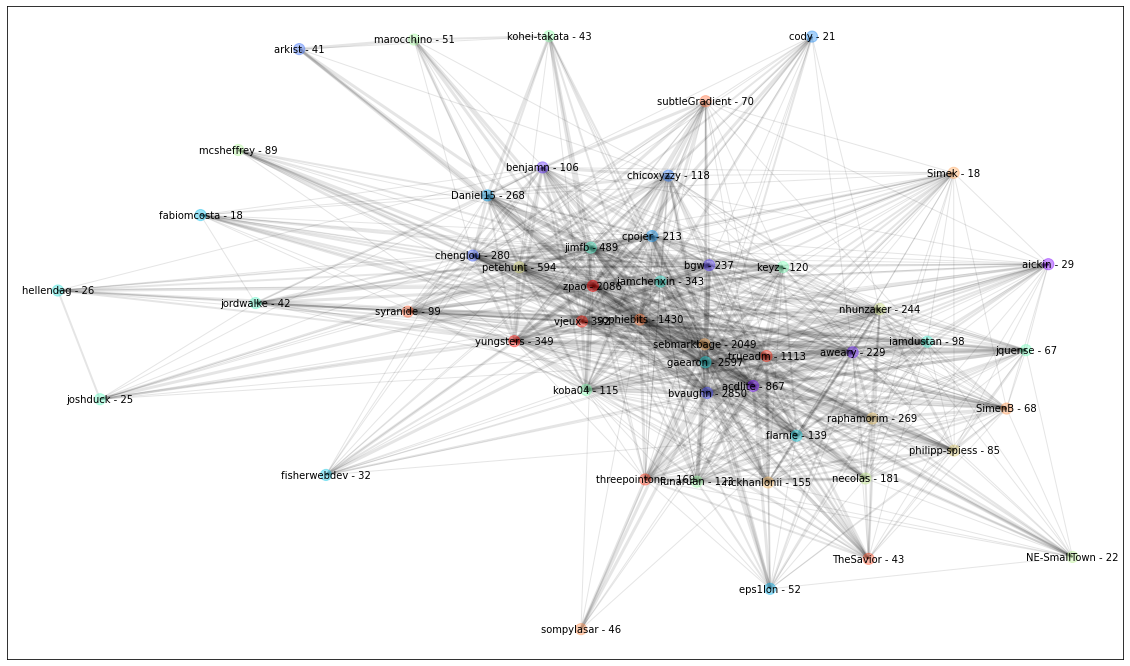

In [8]:
draw_nx_graph(g, index_to_login_, dynamic_width=True)
plt.show()

## Simple embeddings + TSNE
Let's see what happens if we try to get nodes representations and visualise it. I've decided to use node2vec algorithm because it's the most basic and fast way to get vector representations.

In [9]:
edges_list_ = [(str(edge[0]), str(edge[1]), edge[2]['weight']) for edge in edges_list]
graph = Graph(edges_list_, directed=False, weighted=True)
n2v = Node2Vec(graph, dim=25, walk_length=50, context=10, p=4, q=0.8, workers=2)

n2v.train(epochs=100)

Training: 100%|██████████| 5000/5000 [00:01<00:00, 3203.21it/s]


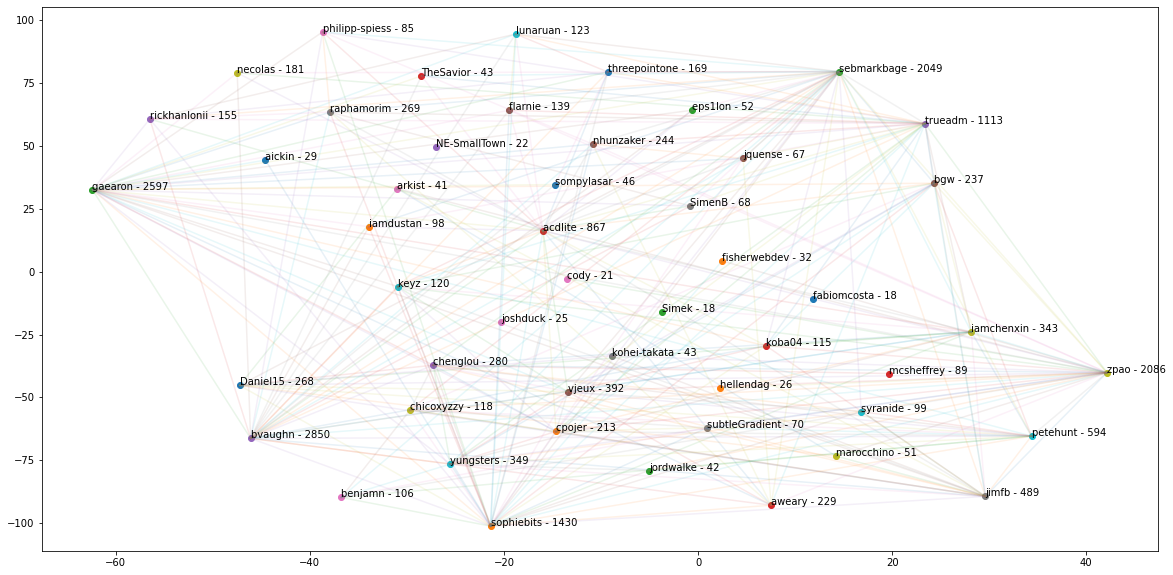

In [10]:
t_repr = tsne2d_representation(n2v.wv.vectors)
edges_filtered = list(filter(lambda x: x[2]['weight'] > 20, edges_list))
draw_representation(t_repr, edges_filtered, df, index_to_login_)
plt.show()

This plot of TSNE representations is more informative than previous one. After getting embeddings from node2vec, nodes have been clustering in two groups. 